In [1]:
import numpy as np
import qml
import glob
from matplotlib import pyplot as plt

import sys
sys.path.insert(0,'/home/misa/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi

In [2]:
# labels
p_labels = '/home/misa/datasets/qm7/values.csv'
atomisation_energies_unsorted = np.loadtxt(p_labels, skiprows=1, delimiter=',', usecols=(0,81))
atomisation_energies_sorted = atomisation_energies_unsorted[atomisation_energies_unsorted[:,0].argsort()].copy()
labels = atomisation_energies_sorted[:,1].copy()

In [3]:
atomisation_energies_sorted

array([[ 0.00000e+00, -4.17960e+02],
       [ 1.00000e+00, -7.12420e+02],
       [ 2.00000e+00, -5.64210e+02],
       ...,
       [ 7.16200e+03, -1.66210e+03],
       [ 7.16300e+03, -1.78201e+03],
       [ 7.16400e+03, -1.91900e+03]])

In [4]:
# load molecule structures
paths_molecules = glob.glob('/home/misa/datasets/qm7/molecules/*.xyz')
sorted_paths = []
for el in paths_molecules:
    m_id = int(el.split('/')[-1].split('__')[0])
    sorted_paths.append((m_id, el))
sorted_paths.sort()

In [5]:
# build representations

In [6]:
# get largest molecule in qm7
msize = []
for p in sorted_paths:
    com=qml.Compound(xyz=p[1])
    msize.append(len(com.coordinates))
msize = np.array(msize)
print('Max number of atoms = {}'.format(np.amax(msize)))

Max number of atoms = 23


In [7]:
max_size = 23
size_U = int(max_size*(max_size + 1)/2) # number of elements in upper triangle of representation matrix
reps = np.zeros((len(labels), size_U))
for idx,p in enumerate(sorted_paths):
    com=qml.Compound(xyz=p[1])
    com.generate_coulomb_matrix(sorting='row-norm', size=23)
    reps[idx] = com.representation

In [8]:
# test correct construction of all reps
comt=qml.Compound(xyz=sorted_paths[1234][1])
comt.generate_coulomb_matrix(sorting='row-norm', size=23)
comt.representation - reps[1234]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [9]:
import sklearn.model_selection as sk

In [10]:
# calculate learning curve
std = []
mae = []
sigma = 560
lam_val = 1e-5
subsets = np.logspace(0, 12, 13, base=2).astype(int)
subsets = np.concatenate((subsets, [5000]))
# subsets=[5000]
for sss in subsets:
    reps_tr, reps_test, labels_tr, labels_test = sk.train_test_split(reps,labels,train_size=sss)
    tr_kernel = qml.kernels.laplacian_kernel(reps_tr, reps_tr, 560)
    tr_kernel += np.identity(len(tr_kernel))*1e-5
    kinv = np.linalg.inv(tr_kernel)
    coeffs = np.dot(kinv, labels_tr)
    test_kernel = qml.kernels.laplacian_kernel(reps_test, reps_tr, 560)
    prediction = np.dot(test_kernel, coeffs)
    mae.append((np.abs(prediction - labels_test)).mean())

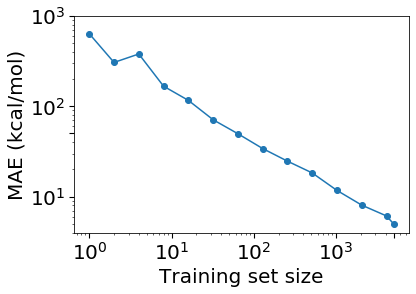

In [25]:
fig, ax = plt.subplots(1,1)
plt.rcParams['font.size'] = 20
ax.plot(subsets, mae, '-o')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Training set size')
ax.set_ylabel('MAE (kcal/mol)')
ax.tick_params(width=1.1, length=5.0)
ax.set_yticks([10, 50,100, 1000])
ax.set_xticks([1,10,100,1000,5000])

directory = '/home/misa/projects/Atomic-Energies/figures/machine_learning/learning_curves/'
plt.savefig(directory+'atomisation_energy_molecule_qm7.png', bbox_inches = 'tight')

### Distribution of atomisation energies

In [11]:
import numpy as np
import qml
import glob
from matplotlib import pyplot as plt
import scipy as sc
from ase.units import Ha

import sys
sys.path.insert(0,'/home/misa/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi

In [12]:
# labels
p_labels = '/home/misa/datasets/qm7/values.csv'
atomisation_energies_unsorted = np.loadtxt(p_labels, skiprows=1, delimiter=',', usecols=(0,81))
atomisation_energies_sorted = atomisation_energies_unsorted[atomisation_energies_unsorted[:,0].argsort()].copy()
labels = atomisation_energies_sorted[:,1].copy()/630
kde_molecule = sc.stats.gaussian_kde(labels)
x_molecule = np.linspace(np.amin(labels)-1, np.amax(labels)+1, 500)

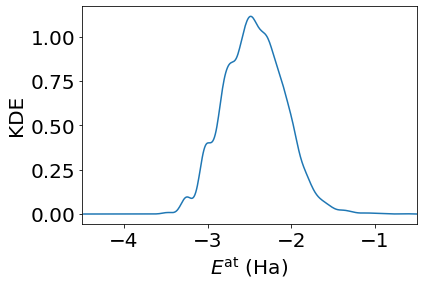

In [14]:
fig, ax = plt.subplots(1,1)
plt.rcParams["font.size"] = 20
ax.plot(x_molecule, kde_molecule.evaluate(x_molecule))
ax.set_xlim(-4.5, -0.5)
ax.set_xlabel(r'$E^{\rm{at}}$ (Ha)')
ax.set_ylabel('KDE')

directory = '/home/misa/projects/Atomic-Energies/figures/machine_learning/analysis_atomic_properties/'
plt.savefig(directory+'kde_atomisation_energy_molecules_qm7.png', bbox_inches = 'tight')

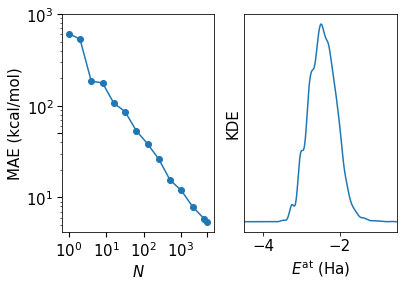

In [19]:
fig, ax = plt.subplots(1,2)
plt.rcParams['font.size'] = 15
ax[0].plot(subsets, mae, '-o')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel(r'$N$')
ax[0].set_ylabel('MAE (kcal/mol)')
ax[0].tick_params(width=1.1, length=5.0)
ax[0].set_yticks([10, 50,100, 1000])
ax[0].set_xticks([1,10,100,1000,5000])



ax[1].plot(x_molecule, kde_molecule.evaluate(x_molecule))
ax[1].set_xlim(-4.5, -0.5)
ax[1].set_xlabel(r'$E^{\rm{at}}$ (Ha)')
ax[1].set_ylabel('KDE')
ax[1].set_yticks([])


directory = '/home/misa/projects/Atomic-Energies/figures/machine_learning/learning_curves/'
plt.savefig(directory+'atomisation_energy_molecule_qm7_and_kde.png', bbox_inches = 'tight')